<a href="https://colab.research.google.com/github/Shegy12/GAN-for-generating-artificial-ECG-data/blob/master/GANy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project description**

Generative Adversial Network for Artificial ECG Generation


# **Konzultacia otazky:**

**Iba 48 signalov?**
* The 48 ECG records from individuals of the MIT-BIH database were used to train the model. 
  * Ano, ale o dlzke 30min, teda celkovo 31,2 miliona samples, ja mám priblizne 10,3 miliona (3120x3308 = 10 320 960)
  * 500 epoch = 3120/100minibatch=31 iteracii je jedna epocha = 31x500=15 500 iterácií, 31x4hodiny= 5 dní

**Vygenerovany ekg signal nic moc**
* The ECGs synthesized using our model were morphologically similar to the real ECGs -> ehm, nope?

**Output layer part?**
* The discriminator includes two pairs of convolution-pooling layers as well as a fully connected layer, a softmax layer, and an output layer from which a binary value is determined based on the calculated one-hot vector.

* After conducting double pairs of operations for convolution and pooling, we add a fully connected layer that connects to a softmax layer, where the output is a one-hot vector. The **two elements** in the vector represent the probability that the input is true or false.

 * Mozna myslene takto : 
    * None,10,50 -> flatten -> None, 50
    * None, 50 -> FC 25 nodes -> None, 25
    * None, 25 -> Softmax 25 nodes - None, 25  (25 one hot vectors)
    * None, 25 -> Output layer 1 node -> 0-1 pravdepodobnost 

**Poradie flattenu v tej 25 fc layer??**
* celá tá tabuľka, P2-> flatten -> 25 FC layer -> 25 softmax layer -> output 1

**Shape 3120,1-hodnoty svodu alebo 3120,2 - cas,hodnoty svodu?**
*  Inspired by their work, in our research, each point sampled from ECG is denoted by a one-dimensional vector of the time-step and leads. 

**Predikovat fake samples kazdy batch 50x(1x3120x5), alebo predikovat raz alebo 1x(50x3120x5) a predict?**

**Myslia d ako latent space?**

* A series of noise data points that follow a Gaussian distribution are fed into the generator as a fixed length sequence. We assume that each noise point can be represented as a d-dimensional one-hot vector and the length of the sequence is T. Thus, the size of the input matrix is T × d. 

**Dat do generatoru vstup None, 3120,1 alebo None,3120,5**

**Merge_mode=sum mam dobre?**

* where the output depends on → ht and ← ht, and h0 is **initialized as a zero vector.**
* merge_mode: Mode by which outputs of the forward and backward RNNs will be combined. One of {'sum', 'mul', 'concat', 'ave', None}. If None, the outputs will not be combined, they will be returned as a list.

**Shape of generated saples-> Batch, 3120, 2 -> preco potom maju diskriminator shape None,3120,1?**
* The output layer is a two-dimensional vector where the first element represents the time step and the second element denotes the lead.

**Inicializacie podla paperu ako?**
* 
recurrent_activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', 
  recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, 
  bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
  recurrent_dropout=0.0, implementation=2, return_sequences=False, 
  return_state=False, go_backwards=False, stateful=False, unroll=False)

**Sigmoid acc problem**
* Ked dam sigmoid aktivaciu do diskriminatoru :
  * model.add(Dense(1, activation='sigmoid'))
  * acc real 1 acc fake 0
  * ked nedam tak je to presne naopak

**Random :**

* While learning, you should see the discriminator loss way below the generator loss. 

* I just switched to global average pooling in the discriminator instead of flattening. Results are starting to look pretty reasonable if you pull the latest example. Enjoy! 

* When things are working, D loss has low variance and goes down over time vs having huge variance and spiking
if loss of generator steadily decreases, then it's fooling D with garbage

# **Install python packages**

In [7]:
!pip3 install scipy keras
#!pip install mat73

# **Imports**

In [0]:
# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import sys
import os
import datetime
from enum import Enum
from pathlib import Path

# numpy
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn

# Basics of Python data handling and visualization

import matplotlib.pyplot as plt
from matplotlib import pyplot
import scipy.io as sio
from timeit import default_timer as timer
import matplotlib as mpl

#keras
from keras.models import Sequential
from keras.layers import Conv1D, TimeDistributed, MaxPooling1D, Dense, Softmax, Flatten, LeakyReLU, Activation, BatchNormalization, Dropout, LSTM, Bidirectional, Reshape
from keras.activations import relu
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.initializers import RandomNormal

#preprocessing
import random
from sklearn import preprocessing
import scipy.stats

# **Google drive**

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

GOOGLE_DRIVE_PATH = Path('/content/gdrive/My Drive')
WORKDIR = 'ECG_DATA' # specify the path to folder which you are intend to work with in this notebook
WORKDIR_PATH = GOOGLE_DRIVE_PATH / WORKDIR

if not os.path.exists(WORKDIR_PATH):
          os.mkdir(WORKDIR_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Paths**

In [0]:
#ANNOTATION - nazvy a anotacie/labely
ANNOTATION_PATH = WORKDIR_PATH / "annotFull.mat"
#MATDATA - signal database (.mat)
SINUS_PATH = WORKDIR_PATH / "SINUS"
AF_SV_VR_PATH = WORKDIR_PATH / "AF_SV_VR"
AB_AV_BB_PV_PATH = WORKDIR_PATH / "AB_AV_BB_PV"
OTHER_NOISY_PATH = WORKDIR_PATH / "OTHER_NOISY"

#**Data manipulation** (signals and labels)

In [5]:
matlab_data = sio.loadmat(file_name=ANNOTATION_PATH)
Ydata = matlab_data['YData']
print('Shape of Ydata ->' + str(Ydata.shape)+', 6884 = number of signals, 2 = signal_names,signal_labels')

signal_names = Ydata[:,0] 
signal_names = [str(signal_names).replace('[', '').replace("'", '').replace(']', '') for signal_names in signal_names.tolist()[:]]
#print('Number of signals ->' + str(len(signal_names)))
print('Names of signals ->' + str(signal_names))

signal_labels = Ydata[:,1]
#signal_labels = [str(signal_labels).replace('[', '').replace(']', '').replace(' ','') for signal_labels in signal_labels.tolist()[:]]
#print('Number of labels ->' + str(len(signal_labels)))
print('Signal labels ->' + str(signal_labels))

labels_names = matlab_data['annotLabel']
labels_names = [str(labels_names).replace('[', '').replace("'", '').replace(']', '').replace('', '') for labels_names in labels_names.tolist()[0]]
print('Names of labels ->' + str(labels_names))

# replace("'",'')


Shape of Ydata ->(6884, 2), 6884 = number of signals, 2 = signal_names,signal_labels
Names of signals ->['EB0000018570.mat', 'EB0000018571.mat', 'EB0000018572.mat', 'EB0000018573.mat', 'EB0000018574.mat', 'EB0000018575.mat', 'EB0000018576.mat', 'EB0000018577.mat', 'EB0000018578.mat', 'EB0000018579.mat', 'EB0000018580.mat', 'EB0000018581.mat', 'EB0000018582.mat', 'EB0000018583.mat', 'EB0000018584.mat', 'EB0000018585.mat', 'EB0000018586.mat', 'EB0000018587.mat', 'EB0000018588.mat', 'EB0000018589.mat', 'EB0000018590.mat', 'EB0000018591.mat', 'EB0000018592.mat', 'EB0000018593.mat', 'EB0000018594.mat', 'EB0000018595.mat', 'EB0000018596.mat', 'EB0000018597.mat', 'EB0000018598.mat', 'EB0000018599.mat', 'EB0000018600.mat', 'EB0000018601.mat', 'EB0000018602.mat', 'EB0000018603.mat', 'EB0000018604.mat', 'EB0000018605.mat', 'EB0000018606.mat', 'EB0000018607.mat', 'EB0000018608.mat', 'EB0000018609.mat', 'EB0000018610.mat', 'EB0000018611.mat', 'EB0000018612.mat', 'EB0000018613.mat', 'EB0000018614.m

# **Creating the database**

**Signaly1** = Signals with MULTIPLE labels (including specific type of label)

**Signaly2** = Signals with ONLY one type of label

In [6]:
AF1=[]; SI1=[];SV1=[];VR1=[];OT1=[];AV1=[];BB1=[];AB1=[];PV1=[];NO1=[]
AF2=[]; SI2=[];SV2=[];VR2=[];OT2=[];AV2=[];BB2=[];AB2=[];PV2=[];NO2=[]

def signal_type(i):
  switcher={
      0:AF2,1:SI2,2:SV2,3:VR2,4:OT2,5:AV2,6:BB2,7:AB2,8:PV2,9:NO2,
      10:AF1,11:SI1,12:SV1,13:VR1,14:OT1,15:AV1,16:BB1,17:AB1,18:PV1,19:NO1
    }
  return switcher.get(i,"Invalid number of label")


prefix=['AF2','SI2','SV2','VR2','OT2','AV2','BB2','AB2','PV2','NO1','AF1','SI1','SV1','VR1','OT1','AV1','BB1','AB1','PV1','NO1']

for counter in range(10,20):
  for item in Ydata.tolist():
    if list(item[1][0])[counter-10] == 1:
      signal_type(counter).append(str(prefix[counter])+str(item[0]).replace('[', '').replace("'", '').replace(']', ''))


print('Signals with MANY types of labels including specific type of label:')
print('')
print('Number of AF1 signals ->' + str(len(signal_type(10))))
print('Number of SI1 signals ->' + str(len(signal_type(11))))
print('Number of SV1 signals ->' + str(len(signal_type(12))))
print('Number of VR1 signals ->' + str(len(signal_type(13))))
print('Number of OT1 signals ->' + str(len(signal_type(14))))
print('Number of AV1 signals ->' + str(len(signal_type(15))))
print('Number of BB1 signals ->' + str(len(signal_type(16))))
print('Number of AB1 signals ->' + str(len(signal_type(17))))
print('Number of PV1 signals ->' + str(len(signal_type(18))))
print('Number of NO1 signals ->' + str(len(signal_type(19))))
print('')

counter=0
for counter in range(10):
  for item in Ydata.tolist():
    if list(item[1][0])[counter] == 1 and sum(list(item[1][0])) < 2:
      signal_type(counter).append(str(prefix[counter])+str(item[0]).replace('[', '').replace("'", '').replace(']', ''))

print('Signals with ONLY one type of label:')
print('')
print('Number of AF2 signals ->' + str(len(signal_type(0))))
print('Number of SI2 signals ->' + str(len(signal_type(1))))
print('Number of SV2 signals ->' + str(len(signal_type(2))))
print('Number of VR2 signals ->' + str(len(signal_type(3))))
print('Number of OT2 signals ->' + str(len(signal_type(4))))
print('Number of AV2 signals ->' + str(len(signal_type(5))))
print('Number of BB2 signals ->' + str(len(signal_type(6))))
print('Number of AB2 signals ->' + str(len(signal_type(7))))
print('Number of PV2 signals ->' + str(len(signal_type(8))))
print('Number of NO2 signals ->' + str(len(signal_type(9))))
print('')

print('Database of signals was created.')

Signals with MANY types of labels including specific type of label:

Number of AF1 signals ->553
Number of SI1 signals ->5942
Number of SV1 signals ->194
Number of VR1 signals ->102
Number of OT1 signals ->88
Number of AV1 signals ->250
Number of BB1 signals ->434
Number of AB1 signals ->418
Number of PV1 signals ->413
Number of NO1 signals ->2183

Signals with ONLY one type of label:

Number of AF2 signals ->267
Number of SI2 signals ->3350
Number of SV2 signals ->89
Number of VR2 signals ->69
Number of OT2 signals ->5
Number of AV2 signals ->0
Number of BB2 signals ->0
Number of AB2 signals ->0
Number of PV2 signals ->0
Number of NO2 signals ->69

Database of signals was created.


#**Signal loading and visualising**

### Problem 1:
Neither scipy.io.savemat, nor scipy.io.loadmat work for MATLAB arrays version 7.3. But the good part is that MATLAB version 7.3 files are hdf5 datasets. So they can be read using a number of tools, including NumPy.

For Python, you will need the h5py extension, which requires HDF5 on your system.

### Solution 1:
Create new database in Matlab (save new .mat files and upload to cloud).
New .mat files were created, 5000samples, 3 columns (II,avR,avL). Also re-work previous cell (names of .mat files are now different)- DONE. We will be working with this as input.

##Lead II

Text(0, 0.5, 'Amplitude [μV]')

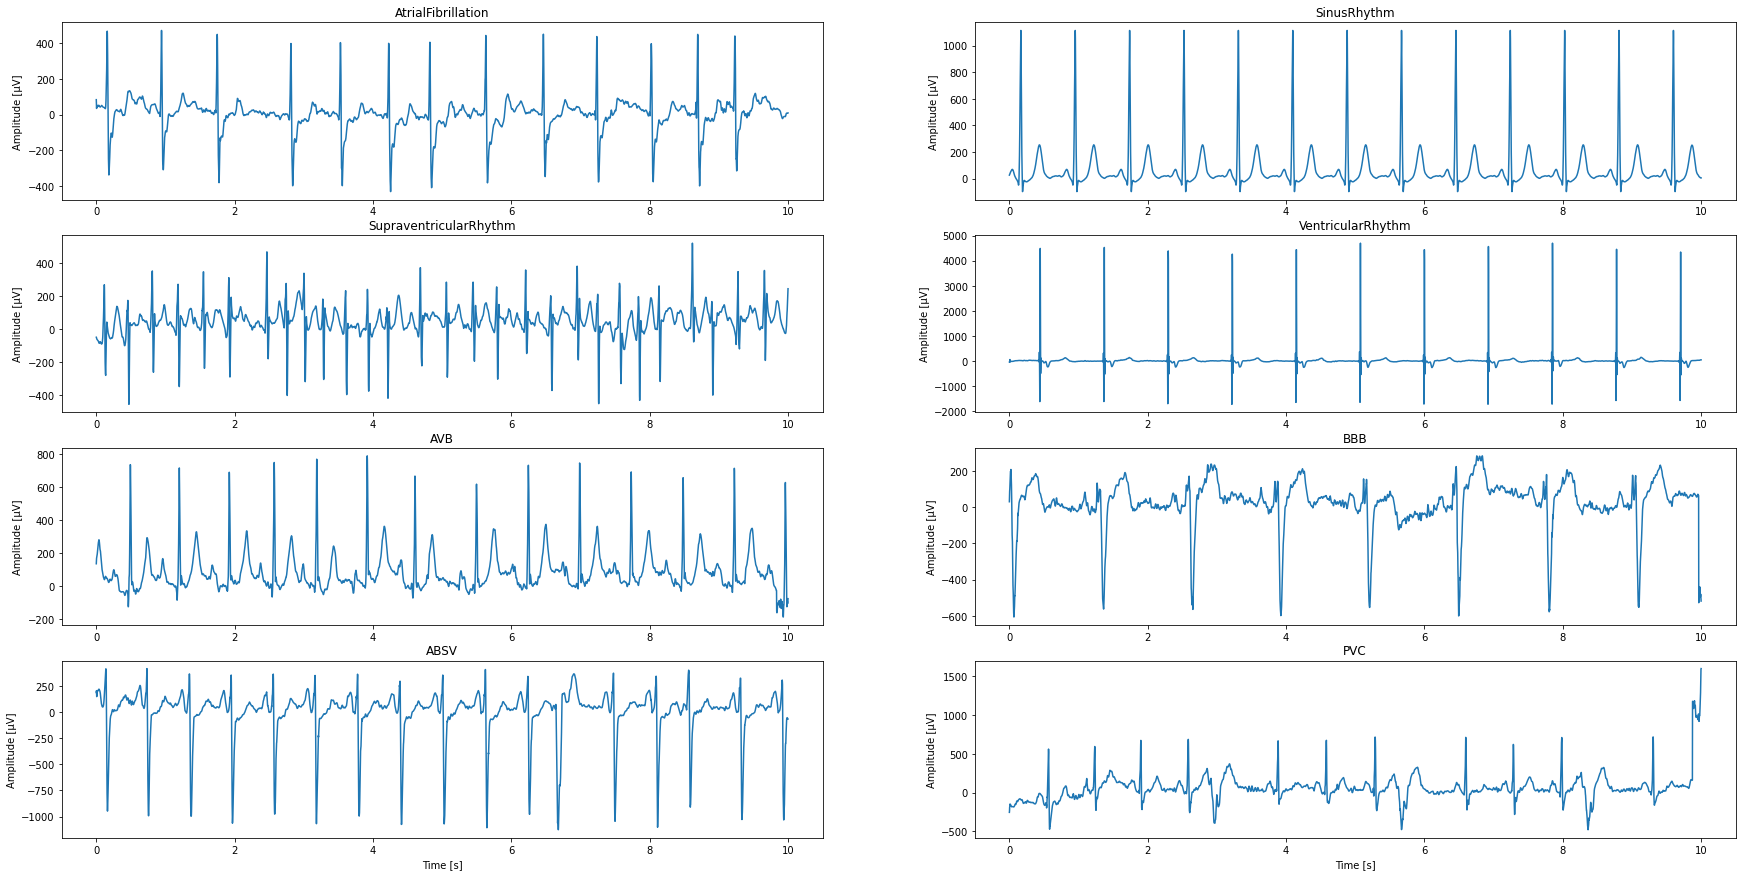

In [12]:
#AF1_PATH=AF_SV_VR_PATH / AF1[0]
#SV1_PATH=AF_SV_VR_PATH / SV1[0]
#VR1_PATH=AF_SV_VR_PATH / VR1[0]

AF2_PATH=AF_SV_VR_PATH / AF2[0]
SI2_PATH=SINUS_PATH / SI2[0]
SV2_PATH=AF_SV_VR_PATH / SV2[0]
VR2_PATH=AF_SV_VR_PATH / VR2[0]
AV1_PATH=AB_AV_BB_PV_PATH / AV1[0]
BB1_PATH=AB_AV_BB_PV_PATH / BB1[0]
AB1_PATH=AB_AV_BB_PV_PATH / AB1[0]
PV1_PATH=AB_AV_BB_PV_PATH / PV1[0]

#AF1_signal=sio.loadmat(AF1_PATH);
#SV1_signal=sio.loadmat(SV1_PATH)
#VR1_signal=sio.loadmat(VR1_PATH);

AF2_signal=sio.loadmat(AF2_PATH)
SI2_signal=sio.loadmat(SI2_PATH)
SV2_signal=sio.loadmat(SV2_PATH)
VR2_signal=sio.loadmat(VR2_PATH)
AV1_signal=sio.loadmat(AV1_PATH);
BB1_signal=sio.loadmat(BB1_PATH)
AB1_signal=sio.loadmat(AB1_PATH);
PV1_signal=sio.loadmat(PV1_PATH)

time_axis=np.linspace(0,10,5000)
plt.figure(figsize=(30,15))
plt.subplot(4, 2, 1)
AF2_signal=AF2_signal['data']
plt.plot(time_axis, (AF2_signal[:,0]))
pyplot.title(labels_names[0])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 2)
SI2_signal=SI2_signal['data']
plt.plot(time_axis, (SI2_signal[:,0]))
pyplot.title(labels_names[1])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 3)
SV2_signal=SV2_signal['data']
plt.plot(time_axis, (SV2_signal[:,0]))
pyplot.title(labels_names[2])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 4)
VR2_signal=VR2_signal['data']
plt.plot(time_axis, (VR2_signal[:,0]))
pyplot.title(labels_names[3])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 5)
AV1_signal=AV1_signal['data']
plt.plot(time_axis, (AV1_signal[:,0]))
pyplot.title(labels_names[5])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 6)
BB1_signal=BB1_signal['data']
plt.plot(time_axis, (BB1_signal[:,0]))
pyplot.title(labels_names[6])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 7)
AB1_signal=AB1_signal['data']
plt.plot(time_axis, (AB1_signal[:,0]))
pyplot.title(labels_names[7])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 8)
PV1_signal=PV1_signal['data']
plt.plot(time_axis, (PV1_signal[:,0]))
pyplot.title(labels_names[8])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')


##AvR

Text(0, 0.5, 'Amplitude [μV]')

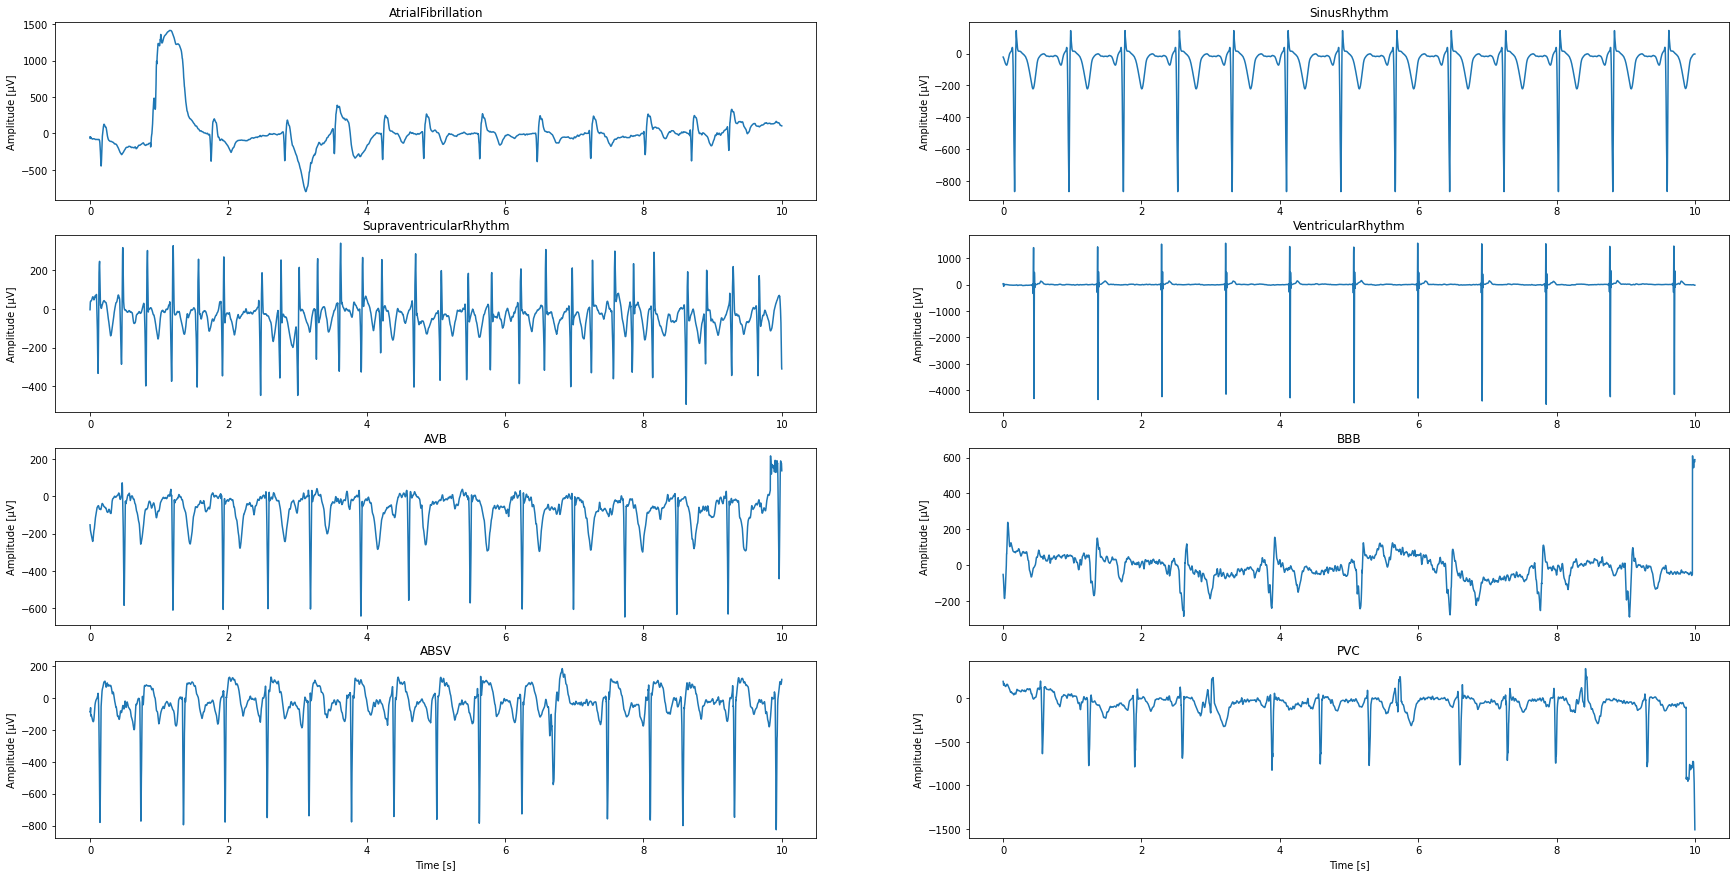

In [13]:
#AF1_PATH=AF_SV_VR_PATH / AF1[0]
#SV1_PATH=AF_SV_VR_PATH / SV1[0]
#VR1_PATH=AF_SV_VR_PATH / VR1[0]

AF2_PATH=AF_SV_VR_PATH / AF2[0]
SI2_PATH=SINUS_PATH / SI2[0]
SV2_PATH=AF_SV_VR_PATH / SV2[0]
VR2_PATH=AF_SV_VR_PATH / VR2[0]
AV1_PATH=AB_AV_BB_PV_PATH / AV1[0]
BB1_PATH=AB_AV_BB_PV_PATH / BB1[0]
AB1_PATH=AB_AV_BB_PV_PATH / AB1[0]
PV1_PATH=AB_AV_BB_PV_PATH / PV1[0]

#AF1_signal=sio.loadmat(AF1_PATH);
#SV1_signal=sio.loadmat(SV1_PATH)
#VR1_signal=sio.loadmat(VR1_PATH);

AF2_signal=sio.loadmat(AF2_PATH)
SI2_signal=sio.loadmat(SI2_PATH)
SV2_signal=sio.loadmat(SV2_PATH)
VR2_signal=sio.loadmat(VR2_PATH)
AV1_signal=sio.loadmat(AV1_PATH);
BB1_signal=sio.loadmat(BB1_PATH)
AB1_signal=sio.loadmat(AB1_PATH);
PV1_signal=sio.loadmat(PV1_PATH)

time_axis=np.linspace(0,10,5000)
plt.figure(figsize=(30,15))
plt.subplot(4, 2, 1)
AF2_signal=AF2_signal['data']
plt.plot(time_axis, (AF2_signal[:,1]))
pyplot.title(labels_names[0])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 2)
SI2_signal=SI2_signal['data']
plt.plot(time_axis, (SI2_signal[:,1]))
pyplot.title(labels_names[1])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 3)
SV2_signal=SV2_signal['data']
plt.plot(time_axis, (SV2_signal[:,1]))
pyplot.title(labels_names[2])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 4)
VR2_signal=VR2_signal['data']
plt.plot(time_axis, (VR2_signal[:,1]))
pyplot.title(labels_names[3])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 5)
AV1_signal=AV1_signal['data']
plt.plot(time_axis, (AV1_signal[:,1]))
pyplot.title(labels_names[5])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 6)
BB1_signal=BB1_signal['data']
plt.plot(time_axis, (BB1_signal[:,1]))
pyplot.title(labels_names[6])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 7)
AB1_signal=AB1_signal['data']
plt.plot(time_axis, (AB1_signal[:,1]))
pyplot.title(labels_names[7])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 8)
PV1_signal=PV1_signal['data']
plt.plot(time_axis, (PV1_signal[:,1]))
pyplot.title(labels_names[8])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')



##avL

numpy.ndarray

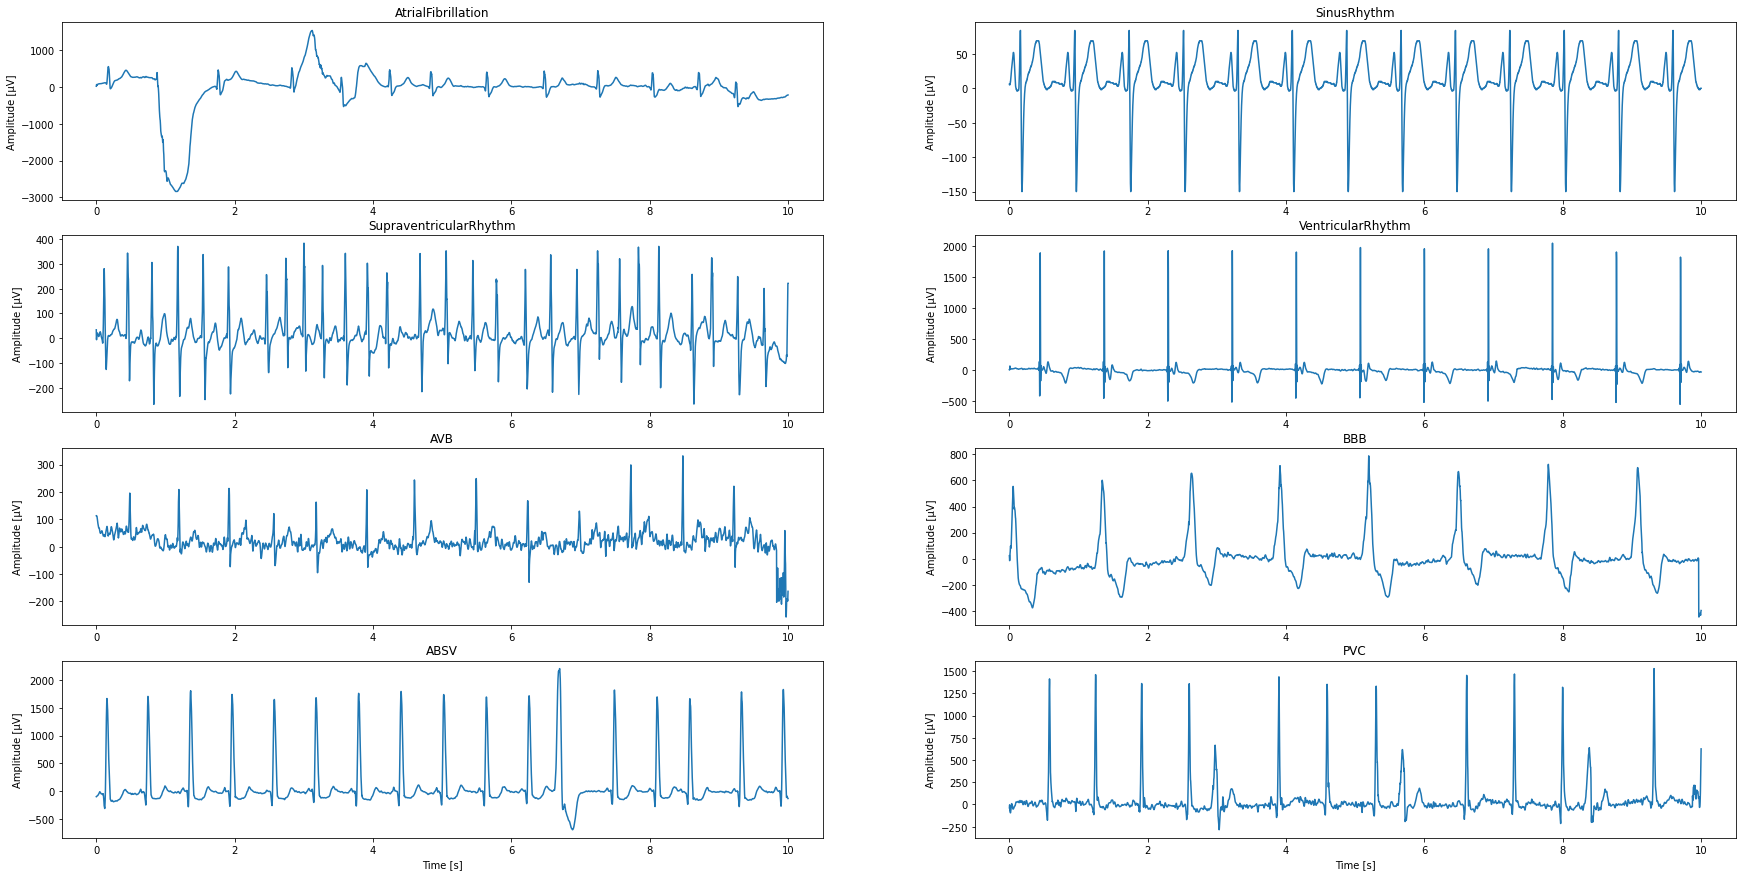

In [15]:
#AF1_PATH=AF_SV_VR_PATH / AF1[0]
#SV1_PATH=AF_SV_VR_PATH / SV1[0]
#VR1_PATH=AF_SV_VR_PATH / VR1[0]

AF2_PATH=AF_SV_VR_PATH / AF2[0]
SI2_PATH=SINUS_PATH / SI2[0]
SV2_PATH=AF_SV_VR_PATH / SV2[0]
VR2_PATH=AF_SV_VR_PATH / VR2[0]
AV1_PATH=AB_AV_BB_PV_PATH / AV1[0]
BB1_PATH=AB_AV_BB_PV_PATH / BB1[0]
AB1_PATH=AB_AV_BB_PV_PATH / AB1[0]
PV1_PATH=AB_AV_BB_PV_PATH / PV1[0]

#AF1_signal=sio.loadmat(AF1_PATH);
#SV1_signal=sio.loadmat(SV1_PATH)
#VR1_signal=sio.loadmat(VR1_PATH);

AF2_signal=sio.loadmat(AF2_PATH)
SI2_signal=sio.loadmat(SI2_PATH)
SV2_signal=sio.loadmat(SV2_PATH)
VR2_signal=sio.loadmat(VR2_PATH)
AV1_signal=sio.loadmat(AV1_PATH);
BB1_signal=sio.loadmat(BB1_PATH)
AB1_signal=sio.loadmat(AB1_PATH);
PV1_signal=sio.loadmat(PV1_PATH)

time_axis=np.linspace(0,10,5000)
plt.figure(figsize=(30,15))
plt.subplot(4, 2, 1)
AF2_signal=AF2_signal['data']
plt.plot(time_axis, (AF2_signal[:,2]))
pyplot.title(labels_names[0])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 2)
SI2_signal=SI2_signal['data']
plt.plot(time_axis, (SI2_signal[:,2]))
pyplot.title(labels_names[1])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 3)
SV2_signal=SV2_signal['data']
plt.plot(time_axis, (SV2_signal[:,2]))
pyplot.title(labels_names[2])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 4)
VR2_signal=VR2_signal['data']
plt.plot(time_axis, (VR2_signal[:,2]))
pyplot.title(labels_names[3])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 5)
AV1_signal=AV1_signal['data']
plt.plot(time_axis, (AV1_signal[:,2]))
pyplot.title(labels_names[5])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 6)
BB1_signal=BB1_signal['data']
plt.plot(time_axis, (BB1_signal[:,2]))
pyplot.title(labels_names[6])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 7)
AB1_signal=AB1_signal['data']
plt.plot(time_axis, (AB1_signal[:,2]))
pyplot.title(labels_names[7])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 8)
PV1_signal=PV1_signal['data']
plt.plot(time_axis, (PV1_signal[:,2]))
pyplot.title(labels_names[8])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')

type(AF2_signal[:,0])


## Signal loading example

In [0]:
AF2_II=[]
for i in range(len(AF2)):
  AF2_PATH=AF_SV_VR_PATH / AF2[i]
  signal=sio.loadmat(AF2_PATH)
  signal=signal['data']
  AF2_II.append(signal[:,0])

AF2_II=np.asarray(AF2_II)

print(np.shape(AF2_II))

AF2_avR=[]
for i in range(len(AF2)):
  AF2_PATH=AF_SV_VR_PATH / AF2[i]
  signal=sio.loadmat(AF2_PATH)
  signal=signal['data']
  AF2_avR.append(signal[:,1])

AF2_avR=np.asarray(AF2_avR)
print(np.shape(AF2_avR))

AF2_avL=[]
for i in range(len(AF2)):
  AF2_PATH=AF_SV_VR_PATH / AF2[i]
  signal=sio.loadmat(AF2_PATH)
  signal=signal['data']
  AF2_avL.append(signal[:,2])

AF2_avL=np.asarray(AF2_avL)

print(np.shape(AF2_avL))

labels=np.ones((len(AF2),1))

print(np.shape(labels))

(267, 5000)
(267, 5000)
(267, 5000)
(267, 1)


##Saving sinus signals

In [0]:
# load real samples of sinus rhythm
SI2_II=[]
for i in range(len(SI2)):
  SI2_PATH=SINUS_PATH / SI2[i]
  signal=sio.loadmat(SI2_PATH)
  signal=signal['data']
  SI2_II.append(signal[1880:5000,0])

SI2_II=np.asarray(SI2_II)
print(np.shape(SI2_II))
np.save(WORKDIR_PATH / "SI2_II_end",SI2_II)


(3350, 3120)


# **EKG CLANOK.pdf**

* We used the MIT-BIH arrhythmia data set provided by the Massachusetts Institute of Technology for studying arrhythmia in our experiments. We downloaded 48 individual records for training. Each record comprised three files, i.e., the header file, data file, and annotation file. Each data file contained about 30 minutes of ECG data. In each record, a **single ECG data point comprised two types of lead values; in this work, we only selected one lead signal for training**

### Parameters

In [0]:
# which signals to load

#subor= "SI2_II.npy"    # start signaly
subor="SI2_II_end.npy"  # end signaly
clip_value_top=2000
clip_value_bottom=1000
clip_value_top2=1200
clip_value_bottom2=540

## Preprocessing the input data
* Delete signals that does not fall into range [2000-(-1000)]
* Clip them to range [1200, 540] - easily normalized after
* Normalize inputs to the range [-1, 1] and use tanh in the generator output.

In [10]:
SI2_II=np.load(WORKDIR_PATH / subor)
SI2_II=np.transpose(SI2_II)
SI2_II=SI2_II.astype('float32')


print('Data type of SI2 ->          ' + str(SI2_II.dtype))
print('Type of SI2 ->               ' + str(type(SI2_II)))
print('Shape of SI2 ->              ' + str(np.shape(SI2_II)))

number_of_signals = SI2_II.shape[1]
length_of_signal = SI2_II.shape[0]

print('Clip value top of SI2 ->         ' + str(clip_value_top) + 'μV')
print('Clip value bottom of SI2 ->      ' + str(clip_value_bottom) + 'μV')

idx=[]
for i in range (number_of_signals):
  for j in range(length_of_signal):
    if SI2_II[j,i] > clip_value_top:
      #SI2_II[j,i]= clip_value
      idx.append(i)
    elif SI2_II[j,i] < (-clip_value_bottom):
      #SI2_II[j,i]= -clip_value
      idx.append(i)

# start of signals ERROR detection
# idx=[]
# for i in range (number_of_signals):
#   for j in range(50):
#     if SI2_II[j,i] > 500:
#       #SI2_II[j,i]= clip_value
#       idx.append(i)
#     elif SI2_II[j,i] < -500:
#       #SI2_II[j,i]= (-clip_value)
#       idx.append(i)


clipped_signals_idx=np.unique(idx)
print('Number of clipped signals -> ' + str(len(clipped_signals_idx)))

# time_axis=np.linspace(0,length_of_signal/500,length_of_signal)
# #Signals visualization 
# for j in clipped_signals_idx:
#   plt.figure(figsize=(6,3))
#   plt.plot(time_axis, (SI2_II[:,j]))
#   pyplot.title(labels_names[1])
#   #pyplot.xlabel('Time [s]')
#   pyplot.ylabel('Amplitude [μV]')

SI2_II=np.delete(SI2_II,clipped_signals_idx[:],1)
print('These signals were deleted.')

number_of_signals = SI2_II.shape[1]
length_of_signal = SI2_II.shape[0]
time_axis=np.linspace(0,length_of_signal/500,length_of_signal)


print('Clip value top of SI2 ->         ' + str(clip_value_top2) + 'μV')
print('Clip value bottom of SI2 ->      ' + str(clip_value_bottom2) + 'μV')

idx=[]
for i in range (number_of_signals):
  for j in range(length_of_signal):
    if SI2_II[j,i] > clip_value_top2:
      SI2_II[j,i]= clip_value_top2
      #idx.append(i)
    elif SI2_II[j,i] < (-clip_value_bottom2):
      SI2_II[j,i]= -clip_value_bottom2
      #idx.append(i)

print('Number of SI2 signals ->     ' + str(number_of_signals))
print('Length of SI2 signals ->     ' + str(length_of_signal))
print('Time axis :')
print(time_axis)
print('Time axis length is :' + str(len(time_axis)))
print('Max of SI_II_11 :' + str(np.amax(SI2_II)))
print('Min of SI_II_11 :' + str(np.amin(SI2_II)))

# range

SI2_II_zscore=scipy.stats.zscore(SI2_II)
SI2_II_01=(SI2_II - np.amin(SI2_II)) / (np.amax(SI2_II) - np.amin(SI2_II))
SI2_II_11=(SI2_II-330)/870

print('Range of Z_score normalization ->     ' + '[' + str(np.amin(SI2_II_zscore)) + ',' + str(np.amax(SI2_II_zscore))+ ']' )
print('Range of 01 normalization ->          ' + '[' + str(np.amin(SI2_II_01)) + ',' + str(np.amax(SI2_II_01))+ ']' )
print('Range of 11 normalization ->          ' + '[' + str(np.amin(SI2_II_11)) + ',' + str(np.amax(SI2_II_11))+ ']' )  

# # scale image data from [0,255] to [-1,1]
# def scale_images(images):
# 	# convert from uint8 to float32
# 	images = images.astype('float32')
# 	# scale from [0,255] to [-1,1]
# 	images = (images - 127.5) / 127.5
# 	return images

Data type of SI2 ->          float32
Type of SI2 ->               <class 'numpy.ndarray'>
Shape of SI2 ->              (3120, 3350)
Clip value top of SI2 ->         2000μV
Clip value bottom of SI2 ->      1000μV
Number of clipped signals -> 81
These signals were deleted.
Clip value top of SI2 ->         1200μV
Clip value bottom of SI2 ->      540μV
Number of SI2 signals ->     3269
Length of SI2 signals ->     3120
Time axis :
[0.00000000e+00 2.00064123e-03 4.00128246e-03 ... 6.23599872e+00
 6.23799936e+00 6.24000000e+00]
Time axis length is :3120
Max of SI_II_11 :1200.0
Min of SI_II_11 :-540.0
Range of Z_score normalization ->     [-8.172488,11.187993]
Range of 01 normalization ->          [0.0,1.0]
Range of 11 normalization ->          [-1.0,1.0]


## Discriminator

* The sequence comprising ECG data points can be regarded as a time series sequence (a normal image requires both a vertical convolution and a horizontal convolution) rather than an image, so only one-dimensional **(1-D) convolution** need to be involved.

* We assume that an input sequence x1, x2, … xT comprises T points, where each is represented by a d-dimensional vector.
 * teda 3120 bodov, kazdy z nich je reprezentoavany jednym bodom v 5D (laten_dim)


* With pairs of convolution-pooling operations, we get the output size as 5x10x1. A fully connected layer which contains 25 neurons connects with P2. The last layer is the softmax-output layer, which outputs the judgement of the discriminator. 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 601, 10)           1210      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 601, 10)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 186, 10)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 51, 5)             1805      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 51, 5)             0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 10, 5)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 50)               

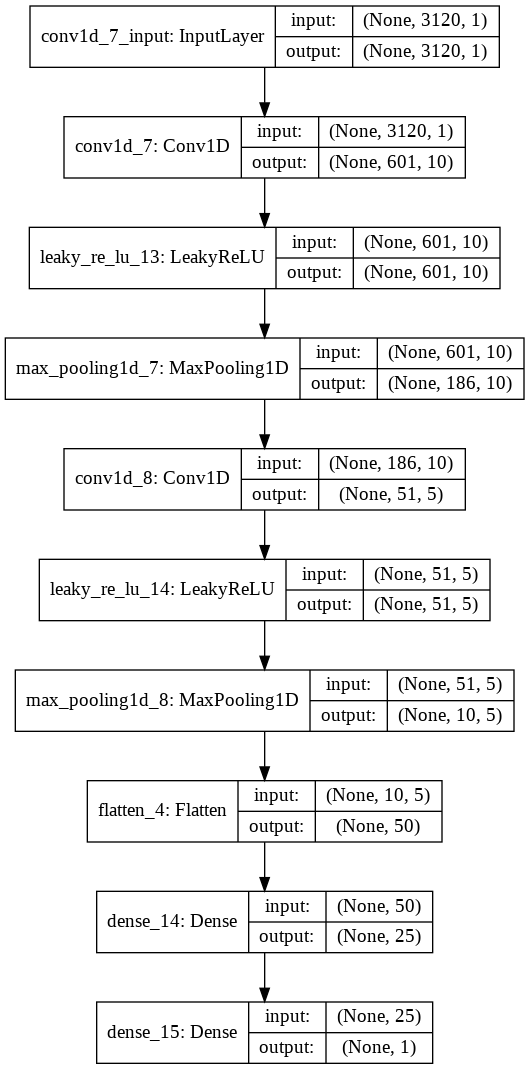

In [33]:
def define_discriminator(input_shape=(3120,1)):
  model = Sequential()
  #model.add(Conv1D(input_shape=(3120,1),filters=10, kernel_size=120, strides=5, padding='valid'))
  model.add(Conv1D(input_shape=(3120,1),filters=10, kernel_size=120, strides=5, padding='valid', data_format='channels_last', dilation_rate=1, 
                   activation=None, use_bias=True, kernel_initializer='he_normal', bias_initializer='zeros', kernel_regularizer=None, 
                   bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
  #model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=46, strides=3, padding='valid', data_format='channels_last'))
  #model.add(Conv1D(filters=5, kernel_size=36, strides=3, padding='valid'))
  model.add(Conv1D(filters=5, kernel_size=36, strides=3, padding='valid', data_format='channels_last', dilation_rate=1, 
                   activation=None, use_bias=True, kernel_initializer='he_normal', bias_initializer='zeros', 
                   kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
  #model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=24, strides=3, padding='valid', data_format='channels_last'))
  #poradie flattenu?
  model.add(Flatten())
  model.add(Dense(25))
  #model.add(Dense(25, activation='softmax'))
  #model.add(Dense(1, activation='softmax'))
  model.add(Dense(1))
  # compile mode
  sgd_D = SGD(lr=0.0001)
  #adam_D = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=sgd_D, metrics=['accuracy'])
  return model

# define the discriminator model
discriminator_model = define_discriminator()
# summarize the model
discriminator_model.summary()
# plot the model
plot_model(discriminator_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

#NOTES:

# BCEWithLogitsLoss() and Sigmoid() doesn't work together, because BCEWithLogitsLoss() includes the Sigmoid activation. 
# So you can use BCEWithLogitsLoss() without Sigmoid() or you can use Sigmoid() and BCELoss()
#1. Use Strided Convolutions - done
#2. Use Batch Normalization - bad results

# Batch normalization standardizes the activations from a prior layer to have a zero mean and unit variance. This has the effect of stabilizing the training process.
# Batch normalization is used after the activation of convolution and transpose convolutional layers in the discriminator and generator models respectively.
# It is added to the model after the hidden layer, but before the activation, such as LeakyReLU.

# OPTIMALIZATION OPTIONS:

# 0 inicializacia
# 1 padding
# 2 umiestnenie flatten vrstvy
# 3 Use label smoothing in the discriminator, with small random noise.  
# 4 Add random noise to the labels in the discriminator.
# 5 Add noise to inputs to the discriminator and decay the noise over time.
# 6 Optimalizer / paper= SGD a mini-batch o dlzke 100/ adam je v GANoch standart
#   sgd = SGD(lr=0.00001) + maybe? -> decay=1e-6, momentum=0.9, nesterov=True
#   adam = Adam(lr=0.0002, beta_1=0.5)
# 7 Remove Fully-Connected Layers
# 8 Use ReLU, Leaky ReLU, and Tanh
# 9 The best practice for DCAGAN models reported in the paper is to initialize all weights using a zero-centered Gaussian distribution (the normal or bell-shaped distribution) with a standard deviation of 0.02.
#   tried with tf.random.normal didnt work
# 10 Kernel size, filters, strides

## Generator

*  series of noise data points that follow a Gaussian distribution are fed into the generator as a fixed length sequence. We assume that each noise point can be represented as a d-dimensional **one-hot vector??** and the length of the sequence is T. Thus, the size of the input matrix is **T × d.** 
* The generator comprises two BiLSTM layers, each having 100 cells. 

* To prevent slow gradient descent due to parameter inflation in the generator, we add a dropout layer and set the probability to 0.5. 

* The output layer is a two-dimensional vector where the first element represents the time step and the second element denotes the lead. ??????????????**??? akoze 3120x1 lead alebo myslia 3120x2 (cas a 1 lead)**

* The generator produces data based on the noise data sampled from a Gaussian distribution, which is **fitted to the real data distribution as accurately as possible.** The inputs for the discriminator are real data and the results produced by the generator, where the aim is to determine whether the input data are real or fake.

* https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

Developing a generator model requires that we transform a vector from the latent space with, 100 dimensions to a 2D array with 32 x 32 x 3, or 3,072 values.

There are a number of ways to achieve this, but there is one approach that has proven effective on deep convolutional generative adversarial networks. It involves two main elements.

The first is a Dense layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image. Specifically, an image half the size (one quarter the area) of the output image would be 16x16x3, or 768 nodes, and an image one quarter the size (one eighth the area) would be 8 x 8 x 3, or 192 nodes.

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 15600)             93600     
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 15600)             0         
_________________________________________________________________
reshape_16 (Reshape)         (None, 3120, 5)           0         
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 3120, 100)         84800     
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 3120, 100)         0         
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 3120, 100)         160800    
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 3120, 100)       

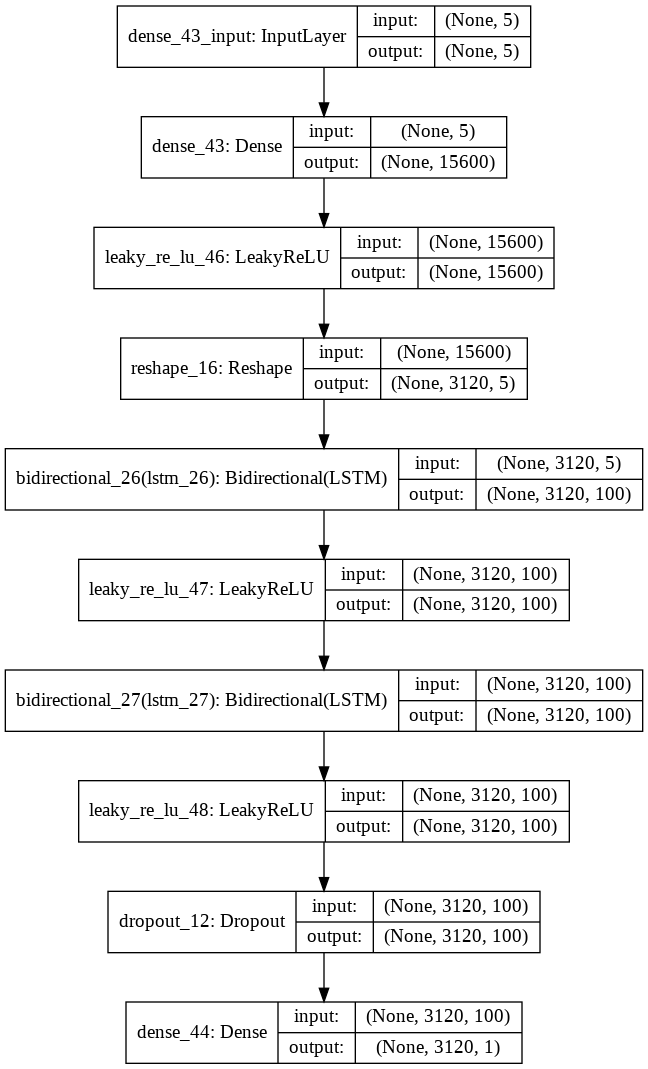

In [142]:
def define_generator(latent_dim):
  model = Sequential()
  model.add(Dense(3120*latent_dim, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((3120, latent_dim)))
  # expected input data shape: (batch_size, timesteps, data_dim)
  model.add(Bidirectional(LSTM(100, return_sequences=True,input_shape=(batch_size,3120,latent_dim)), merge_mode='sum'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Bidirectional(LSTM(100, return_sequences=True),merge_mode='sum'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.5, noise_shape=None, seed=None))
  # The output layer is a two-dimensional vector where the first element represents the time step and the second element denotes the lead.
  model.add(Dense(1, activation='tanh'))
  #model.add(Dense(2,activation='tanh'))
  return model

  # model.add(Bidirectional(LSTM(100, activation='tanh', recurrent_activation='tanh', use_bias=True, kernel_initializer='random_normal', 
  # recurrent_initializer='zeros', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, 
  # bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
  # recurrent_dropout=0.0, implementation=2, return_sequences=True, 
  # return_state=False, go_backwards=False, stateful=False, unroll=False),input_shape=(3120,latent_dim), merge_mode='sum'))
  # return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

  #model.add(Bidirectional(LSTM(100, activation='tanh', recurrent_activation='tanh', use_bias=True, kernel_initializer='random_normal', 
  #recurrent_initializer='zeros', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, 
  #bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
  #recurrent_dropout=0.0, implementation=2, return_sequences=True, 
  #return_state=False, go_backwards=False, stateful=False, unroll=False),merge_mode='sum'))


# size of the latent space
latent_dim =5
# define the generator model
generator_model = define_generator(latent_dim)
# summarize the model
generator_model.summary()
# plot the model
plot_model(generator_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)


# NOTES:

# 1 Return sequences - TRUE
# 2 Use dropout of 50 percent during train and generation. - ALREADY USING
# 3 Normalize inputs to the range [-1, 1] and use tanh in the generator output. - DONE
# 4 Recurrent_activation: Activation function to use for the recurrent step (see activations). Default: hard sigmoid (hard_sigmoid). 
#   If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
# 5 LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
#   It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. ” alebo [-1,1] ak mam tanh

# OPTIMALIZATION OPTIONS:

# 1 Use Leaky ReLU in the generator and discriminator.
# 2 The best practice for DCAGAN models reported in the paper is to initialize all weights using 
#   a zero-centered Gaussian distribution (the normal or bell-shaped distribution) with a standard deviation of 0.02.

## Possible tuning


### https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

### TO TRY:

*   Use label smoothing in the discriminator, with small random noise.
*   Add random noise to the labels in the discriminator.
*   Use DCGAN architecture, unless you have a good reason not to.
*   A loss of 0.0 in the discriminator is a failure mode.
*   If loss of the generator steadily decreases, it is likely fooling the      discriminator with garbage images.
*   Use mini batches of all real or all fake for calculating batch norm 
*   Add noise to inputs to the discriminator and decay the noise over time.statistics. **?**

### ALREADY TRIED:

*   Use labels if you have them.**DONE**
*   Use dropout of 50 percent during train and generation. **DONE**
*     Normalize inputs to the range [-1, 1] and use tanh in the generator output. - **DONE**
*   Flip the labels and loss function when training the generator. - **DONE**
*   Sample Gaussian random numbers as input to the generator. - **DONE**
*   Use Leaky ReLU in the generator and discriminator. **DONE**
*   Use Average pooling and stride for downsampling; use ConvTranspose2D and stride for upsampling. **MAX POOLING, CONV1D**

### T81-558: Applications of Deep Neural Networks¶

https://github.com/jeffheaton/t81_558_deep_learning/blob/c889939162c17d475dfe6dc37b5440d21293acdb/t81_558_class_07_2_Keras_gan.ipynb


* No pre-processing was applied to training images besides scaling to the range of the tanh activation function [-1, 1].
* All models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of 128.
* All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.
* In the LeakyReLU, the slope of the leak was set to 0.2 in all models.
* We used the Adam optimizer(Kingma & Ba, 2014) with tuned hyperparameters.
  * We found the suggested learning rate of 0.001, to be too high, using 0.0002 instead.
  * Additionally, we found leaving the momentum term $\beta{1}$ at the suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped stabilize training.

### NEW:

* 1. Large kernels and more filters
* 2. Flip labels (Generated=True, Real=False)
* 3. Soft and Noisy labels
* 6. Look at the Gradients
https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9



## Generating fake and real signals

* generator.predict - batch size nechapem?



Mean of SI2_II_11_mean :
-0.2947572
Std of SI2_II_11_mean :
0.05133453
Latent space points shape:
(10, 5)
Latent space 5 dimensions, 10 samples : 
[[-0.37264561 -0.22923494 -0.31828182 -0.28056429 -0.30264196]
 [-0.26922523 -0.3185166  -0.29328714 -0.30143254 -0.32428658]
 [-0.28639624 -0.33521232 -0.31556874 -0.33073335 -0.26117703]
 [-0.26974666 -0.25377123 -0.40330963 -0.37330331 -0.26608826]
 [-0.32906145 -0.27439764 -0.38650168 -0.35247298 -0.22647091]
 [-0.39401089 -0.36988963 -0.32649667 -0.28667044 -0.2714087 ]
 [-0.39277398 -0.29297817 -0.34778651 -0.25949965 -0.32621581]
 [-0.36043204 -0.25843827 -0.34545546 -0.29886544 -0.35246303]
 [-0.37588564 -0.38070467 -0.3004904  -0.27692333 -0.23361601]
 [-0.24316291 -0.3258041  -0.32135054 -0.27696861 -0.33340238]]


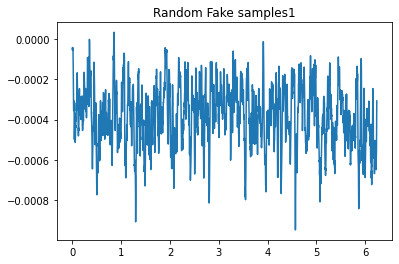

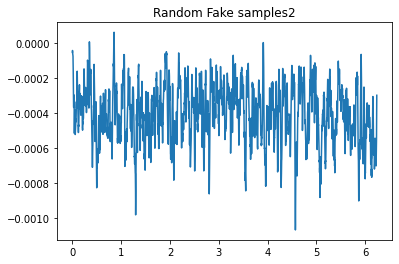

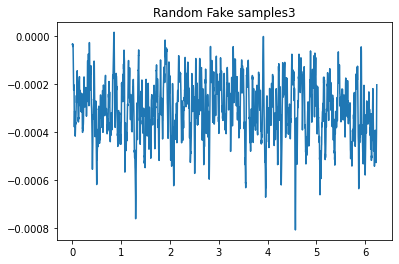

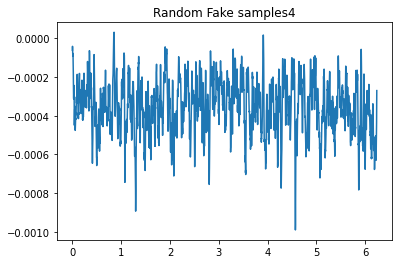

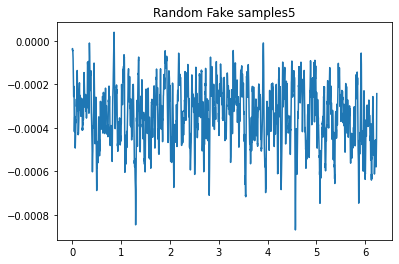

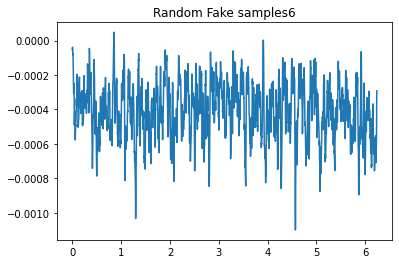

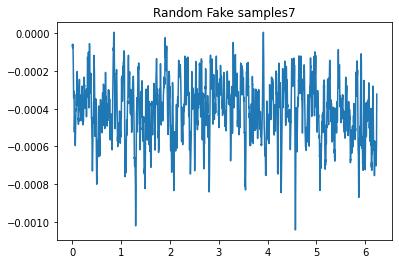

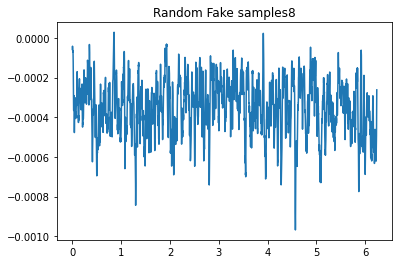

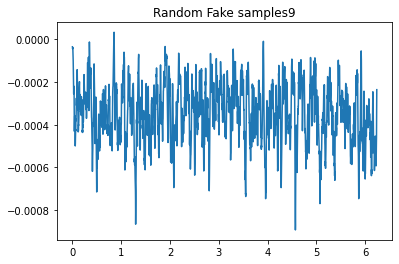

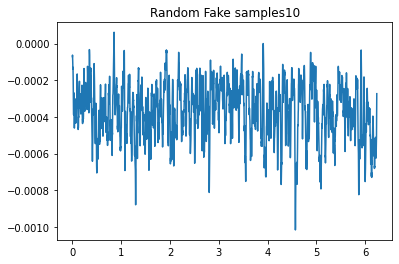

Fake data points shape:
(10, 3120, 1)
Fake data  points [0]:
[-7.1342918e-05 -6.3034524e-05 -7.3678413e-05 ... -4.3678403e-04
 -3.5423352e-04 -2.7351966e-04]


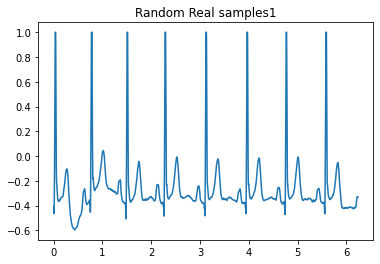

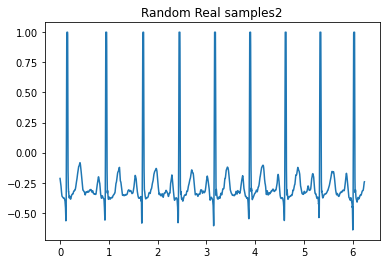

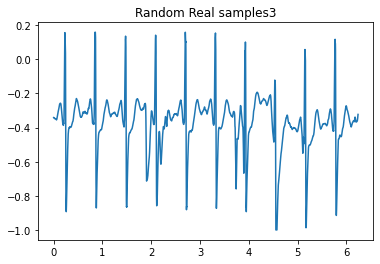

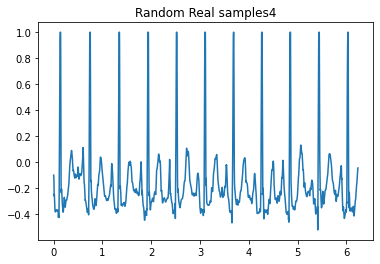

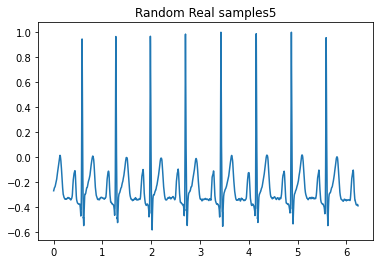

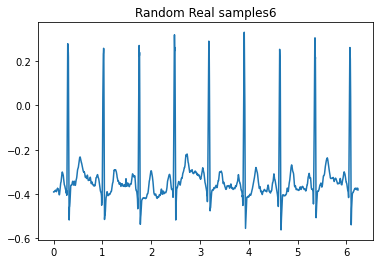

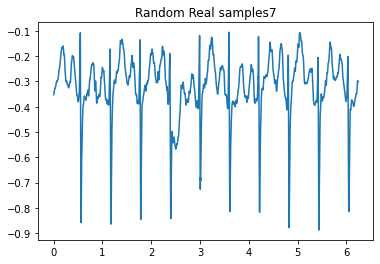

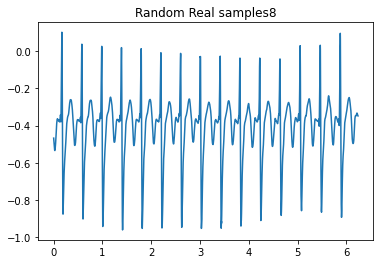

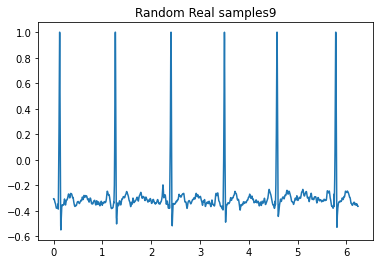

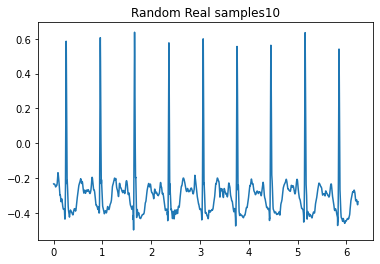

Real data points shape:
(10, 3120, 1)
Real data  points [0]:
[[-0.40804598]
 [-0.40689656]
 [-0.43448275]
 ...
 [-0.33103448]
 [-0.33103448]
 [-0.33103448]]
Length of Real data  points [0]:
3120


In [143]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim,batch_size,mu,sigma):
  # generate points in the latent space
  #X = np.random.normal(mu,sigma, size=(length_of_signal* latent_dim*batch_size))
  X = np.random.normal(mu,sigma, size=(batch_size* latent_dim))
  #original
  #X=X.reshape(1,length_of_signal,latent_dim) batch x 3120 x 5
  #test2
  #X=X.reshape(length_of_signal,latent_dim) # 3120x5
  #test3
  X=X.reshape(batch_size,latent_dim) #batch x 5
  return X

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, batch_size,mu,sigma):
  # generate points in latent space
  X = generate_latent_points(latent_dim, batch_size,mu,sigma)
  # predict outputs
  x_input = generator_model.predict(X)
  # create class labels
  y = np.zeros((batch_size, 1))
  return x_input,y #y2

def generate_real_samples(batch_size,signal):
  X=[]
  cisla=[]
  for i in range (batch_size):
    cislo_signalu=random.randint(0, signal.shape[1]-1)
    X.append(signal[:,cislo_signalu])
    #randomness control - if it generates random numbers everytime
    #cisla.append(cislo_signalu)
  X=np.asarray(X)
  X=X.reshape(batch_size,length_of_signal,1)
  y = np.ones((batch_size,1))
  #y2 = np.ones((batch_size,length_of_signal))
  #y2 = y.reshape(batch_size,length_of_signal,1)
  return X,y #cisla,y2

# signal statistics for gaussian distributions

SI2_II_11_mean=np.mean(np.mean(SI2_II_11, axis=0))
SI2_II_11_std=np.std(np.std(SI2_II_11, axis=0))

print('Mean of SI2_II_11_mean :')
print(SI2_II_11_mean)
print('Std of SI2_II_11_mean :')
print(SI2_II_11_std)  

latent_space=generate_latent_points(latent_dim=5,batch_size=10,mu=SI2_II_11_mean,sigma=SI2_II_11_std)
print('Latent space points shape:')
print(np.shape(latent_space))
print('Latent space 5 dimensions, 10 samples : ')
print(latent_space)

# generate fake samples
fake_data,y = generate_fake_samples(generator_model, latent_dim,batch_size=10, mu=SI2_II_11_mean, sigma=SI2_II_11_std)
for i in range(10): 
  # plot samples
  plt.plot(time_axis, fake_data[i][:,0])
  pyplot.title('Random Fake samples'+ ''+ str(i+1)) 
  pyplot.show()

print('Fake data points shape:')
print(np.shape(fake_data))
print('Fake data  points [0]:')
print(fake_data[i][:,0])

# generate samples
real_data,y = generate_real_samples(10,SI2_II_11)
# plot samples
for i in range(10): 
  plt.plot(time_axis, real_data[i])
  pyplot.title('Random Real samples'+ ''+ str(i+1)) 
  pyplot.show()

print('Real data points shape:')
print(np.shape(real_data))
print('Real data  points [0]:')
print(real_data[0])
print('Length of Real data  points [0]:')
print(len(real_data[0]))

#x_input2=(x_input-noise_min)/(noise_max-noise_min)*(avg_max-avg_min)+avg_min 
#print(np.shape(y2))
#print(np.shape(x_input))
#print(np.shape(x_input2))
#print(np.shape(X))
#print(type(X))
#print(np.shape(X_fake))
#print (np.shape(SI2_II))
#print(np.shape(real_data))
#print(np.shape(fake_data))

#print(np.shape(latent_space))


### As the generator has not been trained, the generated points are complete rubbish, as we expect, but we can imagine that as the model is trained, these points will slowly begin to resemble signal.

## Training the discriminator

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

In [149]:
#lepsie dokumentaciu pozriet na evaluation + clanok na eval GAN in keras kuknut

# create training and testing database 
number_of_train_signals=int(np.round(number_of_signals*0.8))
SI2_II_11_train=SI2_II_11[:,0:number_of_train_signals]
SI2_II_11_test=SI2_II_11[:,number_of_train_signals:number_of_signals]

print('Shape of TRAIN SI2 signals->     ' + str(np.shape(SI2_II_11_train)))
print('Shape of TEST SI2 signals ->     ' + str(np.shape(SI2_II_11_test)))

# use one-sided soft real/fake labels
# Salimans et al., 2016
# https://arxiv.org/pdf/1606.03498.pdf (Section 3.4)
# soft_zero, soft_one = 0, 0.95

# train the discriminator model
def train_discriminator(model, n_epochs, batch_size):
	loss_fake=list()
	loss_real=list()
	half_batch = int(batch_size / 2)
	# run epochs manually
	for i in range(n_epochs):
		# # generate real examples
		# X_real, y_real = generate_real_samples(half_batch,SI2_II_11)
		# X_real_train, y_real_train = generate_real_samples(half_batch,SI2_II_11_train)
		# X_real_test, y_real_test = generate_real_samples(half_batch,SI2_II_11_test)
		# # update model
		# model.train_on_batch(X_real, y_real)
		# #model.train_on_batch(X_real_train, y_real_train)
		# # generate fake examples
		# X_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch,SI2_II_11_mean,SI2_II_11_std)
		# # update model
		# model.train_on_batch(X_fake, y_fake)
		# # evaluate the model
		# loss_real, acc_real = model.evaluate(X_real, y_real, batch_size=None,verbose=0)
		# #loss_real_train, acc_real_train = model.evaluate(X_real_train, y_real_train, batch_size=None,verbose=0)
		# #loss_real_test, acc_real_test = model.evaluate(X_real_test, y_real_test, batch_size=None,verbose=0)
		# loss_fake, acc_fake = model.evaluate(X_fake, y_fake, batch_size=None,verbose=0)
		# #batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. 
		# #Do not specify the batch_size is your data is in the form of symbolic tensors, generators, or keras.utils.Sequence instances (since they generate batches).

		# prepare real samples
		x_real_train, y_real_train = generate_real_samples(half_batch,SI2_II_11_train)
		x_real_test, y_real_test = generate_real_samples(half_batch,SI2_II_11_test)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch, SI2_II_11_mean, SI2_II_11_std)
		#stack them together
		X_stack, Y_stack = np.vstack((x_real_train, x_fake)), np.vstack((y_real_train, y_fake))
		# update discriminator model weights
		discriminator_model.train_on_batch(X_stack, Y_stack)
		#evaluate
		loss_real_train, acc_real_train = model.evaluate(x_real_train, y_real_train, batch_size=None,verbose=0)
		loss_real_test, acc_real_test = model.evaluate(x_real_test, y_real_test, batch_size=None,verbose=0)
		loss_fake, acc_fake = model.evaluate(x_fake, y_fake, batch_size=None,verbose=0)

		print('Epoch -> ', i)
		print('Loss Train','          ','Loss Test','              ','Loss Fake')
		print(loss_real_train,'  ', loss_real_test,'     ',loss_fake)
		print('Accuracies:')
		print('Train','               ','Test','                   ','Fake')
		print(acc_real_train,'  ', acc_real_test,'      ',acc_fake)

# define the discriminator model
discriminator_model = define_discriminator(input_shape=(3120,1))
# fit the model
train_discriminator(discriminator_model, 500, 100)



Shape of TRAIN SI2 signals->     (3120, 2615)
Shape of TEST SI2 signals ->     (3120, 654)
Epoch ->  0
Loss Train            Loss Test                Loss Fake
0.6808310413360595    0.7318636107444764       0.0007315353536978364
Accuracies:
Train                 Test                     Fake
0.47999998927116394    0.47999998927116394        1.0
Epoch ->  1
Loss Train            Loss Test                Loss Fake
0.6216058301925659    0.7096374464035035       0.0009687832440249622
Accuracies:
Train                 Test                     Fake
0.5600000023841858    0.47999998927116394        1.0
Epoch ->  2
Loss Train            Loss Test                Loss Fake
0.6320234060287475    0.6708576560020447       0.001168393325060606
Accuracies:
Train                 Test                     Fake
0.5600000023841858    0.47999998927116394        1.0
Epoch ->  3
Loss Train            Loss Test                Loss Fake
0.6130226540565491    0.5997274112701416       0.0013716017361730336
Accura

KeyboardInterrupt: ignored

## Training the generator

Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space, generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

To be clear, we are not talking about a new third model, just a logical third model that uses the already-defined layers and weights from the standalone generator and discriminator models.

The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

When training the generator via this subsumed GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating plausible fake samples.

Gan model summary :
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_28 (Sequential)   (None, 3120, 1)           339301    
_________________________________________________________________
sequential_34 (Sequential)   (None, 1)                 4316      
Total params: 343,617
Trainable params: 339,301
Non-trainable params: 4,316
_________________________________________________________________
Gan model plot: 


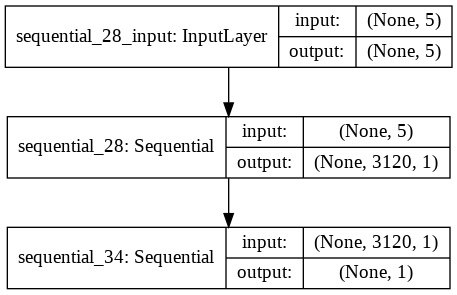

In [151]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	sgd = SGD(lr=0.0001)
	model.compile(loss='binary_crossentropy', optimizer=sgd)
	return model

# create the gan
gan_model = define_gan(generator_model, discriminator_model)
# summarize gan model
print('Gan model summary :')
gan_model.summary()
# plot gan model
print('Gan model plot: ')
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

# # train the composite model
# def train_gan(gan_model, latent_dim, n_epochs=500, batch_size):
# 	# manually enumerate epochs
# 	for i in range(n_epochs):
# 		# prepare points in latent space as input for the generator
# 		x_gan = generate_latent_points(latent_dim, batch_size)
# 		# create inverted labels for the fake samples
# 		y_gan = ones((batch_size, 1))
# 		# update the generator via the discriminator's error
# 		gan_model.train_on_batch(x_gan, y_gan)
	
# train_gan(gan_model,latent_dim,500)

## Training GAN - complete model

*  Each model was trained for **500 epochs** with a **batch size of 100**, where the length of the sequence comprised a series of ECG 3120 points and the learning rate was **1 × 10−5.** 

*  The dim for the noise data points was set to **5** and the **length of the generated ECGs was 400.** 

* It is well known that under normal circumstances, the average heart rate is 60 to 100 in a second. Therefore, the normal cardiac cycle time is between 0.6 s to 1 s. Based on the sampling rate of the MIT-BIH, the calculated length of a generated ECG cycle is between 210 and 360. Figure 8 shows the results of RMSE and FD by different specified lengths from 50–400. From Fig. 8, we can conclude that the quality of generation is optimal when the generated length is 250 (RMSE: 0.257, FD: 0.728). 

* **Try this from article :** One probable cause that comes to mind is that you're simultaneously training discriminator and generator. This will cause discriminator to become much stronger, therefore it's harder (nearly impossible) for generator to beat it, and there's no room for improvement for discriminator. Usually generator network is trained more frequently than the discriminator.

**When things are working, D loss has low variance and goes down over time vs having huge variance and spiking
if loss of generator steadily decreases, then it's fooling D with garbage (says martin)**

The discriminator model is updated twice per batch, once with real samples and once with fake samples, which is a best practice as opposed to combining the samples and performing a single update.

Finally, we report the loss each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate.

Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch. The generator loss is less critical and may hover between 0.5 and 2 or higher. A clever programmer might even attempt to detect the crashing loss of the discriminator, halt, and then restart the training process.

In [0]:
# create and save a plot of generated images
def save_plot(acc_real, acc_fake, x_real,x_fake,length_of_signal,epoch, n=5):
  # plot images
  time_axis=np.linspace(0,length_of_signal/500,length_of_signal)
  fig = plt.figure(figsize=(32,16))
  fig.suptitle('Epoch :'+ "  " + str(epoch)+" | "+'acc_real ='+"  "+str(acc_real)+" | "+'acc_fake ='+"  "+str(acc_fake))
  for i in range(n * n):
    # define subplot
    mysignals = [{'name': 'Real signal', 'x': time_axis, 'y': x_real[i], 'color':'r', 'linewidth':2.5},{'name': 'Fake signal', 'x': time_axis, 'y': x_fake[i], 'color':'b', 'linewidth':2.5}]
    for signal in mysignals:
      ax1 = fig.add_subplot(n, n, 1 + i)
      ax1.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
      #ax1.axis('off')
      #ax1.legend()
  plt.savefig(str(WORKDIR_PATH / "GAN/train5/epoch") + str(epoch))

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, SI2_II_11_test, latent_dim, batch_size, mu, sigma,length_of_signal):
	# prepare real samples
	x_real, y_real = generate_real_samples(batch_size,SI2_II_11_test)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, batch_size, mu, sigma)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(acc_real, acc_fake, x_real,x_fake,length_of_signal,epoch, n=5)
	# save the generator model tile file
	g_model.save(str(WORKDIR_PATH / "GAN/train5/generatormodel") + str(epoch))
  
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, signal_train, signal_test, mu, sigma,length_of_signal, n_epochs=500, batch_size=100, n_eval=5):
  #determine half the size of one batch, for updating the discriminator
  batch_per_epoch = int( SI2_II_11.shape[1] / batch_size)
  half_batch = int(batch_size / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(batch_per_epoch):
      # prepare real samples and test
      x_real,y_real = generate_real_samples(half_batch,signal_train)
      d_loss1, _ = d_model.train_on_batch(x_real, y_real)
      # prepare fake examples
      #x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch, SI2_II_11_train_mean, SI2_II_11_train_std)
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch, mu, sigma)
      d_loss2, _ = d_model.train_on_batch(x_fake, y_fake)
      # prepare points in latent space as input for the generator
      x_gan = generate_latent_points(latent_dim, batch_size,mu,sigma)
      # create inverted labels for the fake samples
      y_gan = ones((batch_size, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
    # evaluate the model performance, sometimes
    if (i+1) % n_eval == 0:
      summarize_performance(i+1, g_model, d_model, signal_test, latent_dim, batch_size, SI2_II_11_train_mean, SI2_II_11_train_std, length_of_signal)

# create training and testing database 

number_of_train_signals=int(np.round(number_of_signals*0.8))
SI2_II_11_train=SI2_II_11[:,0:number_of_train_signals]
SI2_II_11_test=SI2_II_11[:,number_of_train_signals:number_of_signals]
print('Shape of TRAIN SI2 signals->     ' + str(np.shape(SI2_II_11_train)))
print('Shape of TEST SI2 signals ->     ' + str(np.shape(SI2_II_11_test)))

# signal statistics for gaussian distributions - z celeho alebo iba z train?
SI2_II_11_train_mean=np.mean(np.mean(SI2_II_11_train, axis=0))
SI2_II_11_train_std=np.std(np.std(SI2_II_11_train, axis=0))
print('Mean of SI2_II_11_train_mean :')
print(SI2_II_11_train_mean)
print('Std of SI2_II_11_train_std :')
print(SI2_II_11_train_std)

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim, SI2_II_11_train, SI2_II_11_test, SI2_II_11_train_mean, SI2_II_11_train_std, length_of_signal, n_epochs=500, batch_size=100, n_eval=5)

Shape of TRAIN SI2 signals->     (3120, 2615)
Shape of TEST SI2 signals ->     (3120, 654)
Mean of SI2_II_11_train_mean :
-0.29484928
Std of SI2_II_11_train_std :
0.05224278


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/32, d1=13.062, d2=0.001 g=6.436
>1, 2/32, d1=12.560, d2=0.006 g=2.366
>1, 3/32, d1=6.498, d2=0.008 g=2.336
>1, 4/32, d1=3.608, d2=0.012 g=2.328
>1, 5/32, d1=2.365, d2=0.014 g=2.297
>1, 6/32, d1=3.063, d2=0.014 g=2.331
>1, 7/32, d1=0.580, d2=0.015 g=2.304
>1, 8/32, d1=0.864, d2=0.017 g=2.307
>1, 9/32, d1=0.384, d2=0.017 g=2.299
>1, 10/32, d1=0.417, d2=0.017 g=2.304
>1, 11/32, d1=0.385, d2=0.018 g=2.317
>1, 12/32, d1=0.268, d2=0.018 g=2.316
>1, 13/32, d1=0.199, d2=0.017 g=2.305
>1, 14/32, d1=0.189, d2=0.017 g=2.326
>1, 15/32, d1=0.249, d2=0.017 g=2.283
>1, 16/32, d1=0.113, d2=0.017 g=2.286
>1, 17/32, d1=0.145, d2=0.017 g=2.274
>1, 18/32, d1=0.113, d2=0.016 g=2.278
>1, 19/32, d1=0.177, d2=0.016 g=2.280
>1, 20/32, d1=0.093, d2=0.015 g=2.272
>1, 21/32, d1=0.065, d2=0.015 g=2.279
>1, 22/32, d1=0.154, d2=0.015 g=2.284
>1, 23/32, d1=0.050, d2=0.014 g=2.282
>1, 24/32, d1=0.098, d2=0.013 g=2.261
>1, 25/32, d1=0.093, d2=0.013 g=2.255
>1, 26/32, d1=0.088, d2=0.012 g=2.254
>1, 27/32, d1=0.033